In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from gerrychain import Graph, GeographicPartition, Election, MarkovChain, tree, constraints
from functools import partial
from gerrychain.updaters import Tally, cut_edges
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
import os
from gerrychain.accept import always_accept

from candidate import Candidate

In [2]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd())
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "north carolina", "precinct_level_w_election.shp")
EXPORT_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "north carolina")
ITERATIONS = 3333
SAFE_SEAT_THRESHOLD = 0.66
MINORITY_POP_THRESHOLD = RACE_WINNER_THRESHOLD = 0.5
TOTAL_DISTRICTS = 13
FOUR_FOUR_FIVE = 3.25
FIVE_FIVE_THREE = 2.6
THRE_THREE_THREE_FOUR = 4.33

In [3]:
nc_graph = Graph.from_file(NC_PATH, ignore_errors=True)

/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [4]:
total_population = sum(nc_graph.nodes[node]["TOTPOP"] for node in nc_graph.nodes)

candidate_D1 = Candidate("Democrat1", "Democratic")
candidate_D2 = Candidate("Democrat2", "Democratic")
candidate_D3 = Candidate("Democrat3", "Democratic")
candidate_D4 = Candidate("Democrat4", "Democratic")
candidate_D5 = Candidate("Democrat5", "Democratic")
candidate_R1 = Candidate("Republican1", "Republican")
candidate_R2 = Candidate("Republican2", "Republican")
candidate_R3 = Candidate("Republican3", "Republican")
candidate_R4 = Candidate("Republican4", "Republican")
candidate_R5 = Candidate("Republican5", "Republican")

In [5]:
partition_445 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_population / FOUR_FOUR_FIVE, "TOTPOP", 0.01, 1)
partition_553 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_population / FIVE_FIVE_THREE, "TOTPOP", 0.01, 1)
partition_3334 = tree.recursive_tree_part(nc_graph, [1, 2 ,3, 4], total_population /THRE_THREE_THREE_FOUR, "TOTPOP", 0.01, 1)

nc_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

In [6]:

# Create a new partition with the election results
new_partition445 = GeographicPartition(nc_graph, assignment=partition_445, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })
new_partition553 = GeographicPartition(nc_graph, assignment=partition_553, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

new_partition3334 = GeographicPartition(nc_graph, assignment=partition_3334, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

In [7]:
ideal_pop445 = total_population / FOUR_FOUR_FIVE
proposal445 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop445, epsilon=.02, node_repeats=2)
compactness445 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition445["cut_edges"])
)
pop_constraint445 = constraints.within_percent_of_ideal_population(new_partition445, 0.3)

ideal_pop553 = total_population / FIVE_FIVE_THREE
proposal553 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop553, epsilon=.02, node_repeats=2)
compactness553 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition553["cut_edges"])
)
pop_constraint553 = constraints.within_percent_of_ideal_population(new_partition553, 0.4)

ideal_pop3334 = total_population / THRE_THREE_THREE_FOUR
proposal3334 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop3334, epsilon=.02, node_repeats=2)
compactness3334 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition3334["cut_edges"])
)
pop_constraint3334 = constraints.within_percent_of_ideal_population(new_partition3334, 0.3)



In [8]:
# Print the population of each district
chain445 = MarkovChain(
    proposal=proposal445,
    constraints=[
        compactness445,
        pop_constraint445
    ],
    accept=always_accept,
    initial_state=new_partition445,
    total_steps=ITERATIONS
)

chain553 = MarkovChain(
    proposal=proposal553,
    constraints=[
        compactness553,
        pop_constraint553
    ],
    accept=always_accept,
    initial_state=new_partition553,
    total_steps=ITERATIONS
)

chain3334 = MarkovChain(
    proposal=proposal3334,
    constraints=[
        compactness3334,
        pop_constraint3334
    ],
    accept=always_accept,
    initial_state=new_partition3334,
    total_steps=ITERATIONS
)


In [9]:
import warnings
warnings.filterwarnings('ignore')

polsby_popper_scores = pd.DataFrame()
dem_splits = pd.DataFrame()
rep_splits = pd.DataFrame()
black_pop = pd.DataFrame()
asian_pop = pd.DataFrame()
hisp_pop = pd.DataFrame()
white_pop = pd.DataFrame()
total_pop = pd.DataFrame()
equal_pop = pd.DataFrame()


unique_plans = {}
OPPORTUNITY_REP_COUNT = int(TOTAL_DISTRICTS * 0.25)
print(f"OPPORTUNITY_REP_COUNT: {OPPORTUNITY_REP_COUNT}")

master_dict = {"chain445": chain445, "chain355": chain553, "chain3334": chain3334}
dem_candidates = [candidate_D1, candidate_D2, candidate_D3, candidate_D4, candidate_D5]
rep_candidates = [candidate_R1, candidate_R2, candidate_R3, candidate_R4, candidate_R5]

chain_dict = {}
for link in master_dict:
    all_elections = []
    for step in master_dict[link]:
        blk = pd.Series(step["black"])
        asn = pd.Series(step["asian"])
        hsp = pd.Series(step["hisp"])
        wt = pd.Series(step["white"])
        tot = pd.Series(step["population"])

        polsby_popper_scores = polsby_popper_scores.append(pd.Series(polsby_popper(step)), ignore_index=True)
        black_pop = black_pop.append(pd.Series(step["black"]), ignore_index=True)
        asian_pop = asian_pop.append(pd.Series(step["asian"]), ignore_index=True)
        hisp_pop = hisp_pop.append(pd.Series(step["hisp"]), ignore_index=True)
        white_pop = white_pop.append(pd.Series(step["white"]), ignore_index=True)
        total_pop = total_pop.append(pd.Series(step["population"]), ignore_index=True)
        
        equal_pop = equal_pop.append(pd.Series(max(step["population"].values()) - min(step["population"].values())), ignore_index=True)
        dem_splits = dem_splits.append(pd.Series(step["CongressionalRace"].percents("Democratic")), ignore_index=True)
        rep_splits = rep_splits.append(pd.Series(step["CongressionalRace"].percents("Republican")), ignore_index=True)


        minority_pop = blk + asn + hsp
        minority_pop_percentage = minority_pop / tot
    
        


        election = {}
        for district in step["population"]:

            dem = pd.Series(step["CongressionalRace"].percents("Democratic")[district-1])
            rep = pd.Series(step["CongressionalRace"].percents("Republican")[district-1])
            dem_seat_share_percentage = dem[dem > 0.5].count() / TOTAL_DISTRICTS
            dem_vote_share_percentage = dem.mean()


                
            if "high opportunity rep count" not in unique_plans:    
                if minority_pop_percentage[minority_pop_percentage > 0.3].count().sum() >= OPPORTUNITY_REP_COUNT:
                    unique_plans["high opportunity rep count"] = step
                
            if "high dem vote share skew" not in unique_plans:
                if abs(dem_seat_share_percentage - dem_vote_share_percentage) > 0.15:
                    unique_plans["high vote seat share skew"] = step

            if "democrat split > .6" not in unique_plans:
                if dem.max() > 0.6:
                    unique_plans["democrat split > .6"] = step
            
            if "republican split > .6" not in unique_plans:
                if rep.max() > 0.6:
                    unique_plans["republican split > .6"] = step

            top_candidates = {} # Key = name of candidate, Value = number of votes
            for cand in dem_candidates:
                top_candidates[cand.get_name()] = 0
            for cand in rep_candidates:
                top_candidates[cand.get_name()] = 0
            total_reps = round((step["population"][district] / total_population) * TOTAL_DISTRICTS)
            dem_votes = step["CongressionalRace"].votes("Democratic")[district-1]
            rep_votes = step["CongressionalRace"].votes("Republican")[district-1]
            weight = 1
            for cand in range(total_reps):
                top_candidates[rep_candidates[cand].get_name()] += (weight * rep_votes)
                top_candidates[dem_candidates[cand].get_name()] += (weight * dem_votes)
                weight -= .05
            election[district] = top_candidates
            
            for part in election:
                election[part] = dict(sorted(election[part].items(), key=lambda item: item[1], reverse=True))
        all_elections.append(election)
    chain_dict[master_dict[link]] = all_elections
        
display(f"Number of unique plans: {len(unique_plans)}")

rep_safe_districts = rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
dem_safe_districts = dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
minority_pop = black_pop + asian_pop + hisp_pop
opportunity_reps = minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()
dem_seat_share = dem_splits[dem_splits > RACE_WINNER_THRESHOLD].count(axis=1)
dem_seat_share_percentage =  dem_seat_share / TOTAL_DISTRICTS
dem_vote_share_percentage = dem_splits.mean(axis=1).mean()
rep_seat_share = rep_splits[rep_splits > RACE_WINNER_THRESHOLD].count(axis=1)
rep_seat_share_percentage =  rep_seat_share / TOTAL_DISTRICTS
rep_vote_share_percentage = rep_splits.mean(axis=1).mean()

equal_pop_measure = equal_pop.mean() / (sum(new_partition445["population"].values()) + sum(new_partition553["population"].values()) + sum(new_partition3334["population"].values()))


OPPORTUNITY_REP_COUNT: 3


'Number of unique plans: 4'

In [10]:
print(unique_plans)

{'high vote seat share skew': <GeographicPartition [4 parts]>, 'democrat split > .6': <GeographicPartition [3 parts]>, 'republican split > .6': <GeographicPartition [3 parts]>, 'high opportunity rep count': <GeographicPartition [3 parts]>}


In [11]:
rep_splits.columns  = [i+1 for i in rep_splits.columns]
dem_splits.columns = [i+1 for i in dem_splits.columns]

# Polsby Popper Scores

In [12]:
polsby_popper_scores
polsby_popper_scores.mean()

1    0.217156
2    0.214775
3    0.218341
4    0.202015
dtype: float64

# Republican Party Splits

In [13]:
rep_splits.mean()

1    0.500248
2    0.499617
3    0.497421
4    0.499796
dtype: float64

# Republican Safe Districts

In [14]:
rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count()

1    0
2    0
3    0
4    0
dtype: int64

# Democrat Party Splits

In [15]:
dem_splits.mean()

1    0.499752
2    0.500383
3    0.502579
4    0.500204
dtype: float64

# Democrat Safe Districts

In [16]:
dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count()

1    0
2    0
3    0
4    0
dtype: int64

#  Majority-minority districts

In [17]:
minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()

1    0
2    0
3    0
4    0
dtype: int64

# Vote Share Seat Share
## Democrat

In [18]:
dem_vote_share_percentage

0.5008912656904332

## Republican

In [19]:
rep_vote_share_percentage

0.4991087343095668


# Box & Whisker for Population


In [20]:
black_pop_box_data = pd.DataFrame(black_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
asian_pop_box_data = pd.DataFrame(asian_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
hispanic_pop_box_data = pd.DataFrame(hisp_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
white_pop_box_data = pd.DataFrame(white_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
total_pop_box_data = pd.DataFrame(total_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])


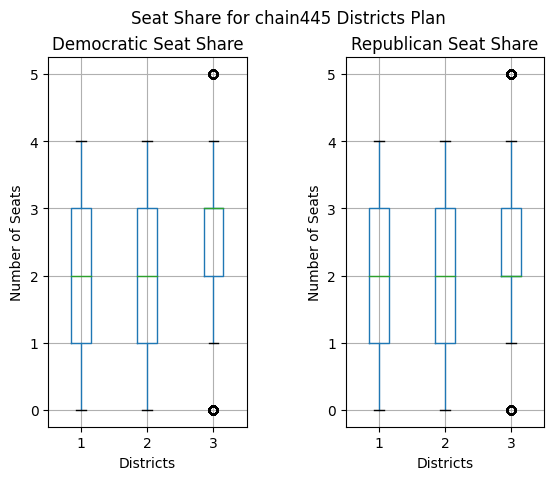

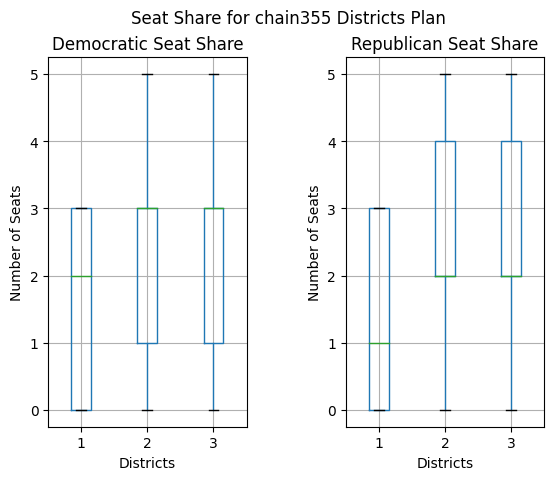

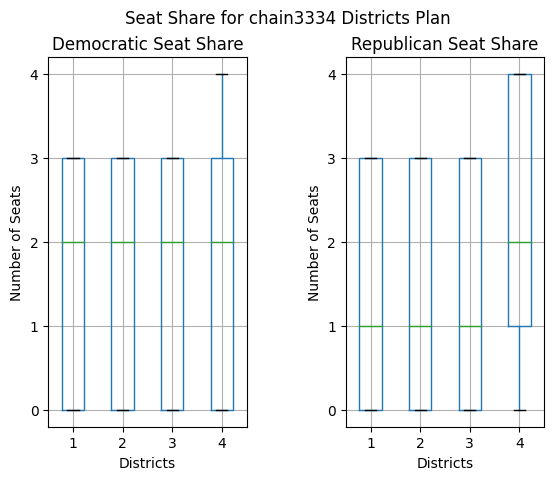

In [21]:
seat_data = {}

# Remove all candidates that have 0 votes
for link in master_dict:
    new_election = []
    for election in chain_dict[master_dict[link]]:
        new_election.append({})
        for district in election:
            new_election[-1][district] = {}
            for candidate in election[district]:
                if election[district][candidate] != 0:
                    new_election[-1][district][candidate] = election[district][candidate]
            

    for election in new_election:
        for district in election:
            # Remove half of the candidates
            election[district] = dict(list(election[district].items())[:int(len(election[district])/2)])
            # Sort districts by number of elements
            election[district] = dict(sorted(election[district].items(), key=lambda item: item[1], reverse=True))

    # Sort the districts by number of elements and re index them
    # District 3 should have the most candidates
    new_election = sorted(new_election, key=lambda x: len(x[len(x)]), reverse=True)
    for i in range(len(new_election)):
        new_election[i] = dict(sorted(new_election[i].items(), key=lambda x: len(x[len(x)-1]), reverse=False))
        new_election[i] = dict(enumerate(new_election[i].values(), start=1))
    chain_dict[master_dict[link]] = new_election
    
    dem_seatshare = []
    rep_seatshare = []
    for election in new_election:
        dem_dict = {}
        rep_dict = {}
        for district in election:
            # Get the number of repubicans and democrats
            num_dem = 0
            num_rep = 0
            for candidate in election[district]:
                if candidate[0] == "D":
                    num_dem += 1
                else:
                    num_rep += 1
            dem_dict[district] = num_rep
            rep_dict[district] = num_dem
        dem_seatshare.append(dem_dict)
        rep_seatshare.append(rep_dict)

    df_dem = pd.DataFrame(dem_seatshare)
    df_rep = pd.DataFrame(rep_seatshare)


    # Group both boxplots together
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    fig.suptitle("Seat Share for " + link + " Districts Plan")
    df_dem.boxplot(ax=ax1)
    ax1.set_title("Democratic Seat Share")
    ax1.set_xlabel("Districts")
    ax1.set_ylabel("Number of Seats")
    df_rep.boxplot(ax=ax2)
    ax2.set_title("Republican Seat Share")
    ax2.set_xlabel("Districts")
    ax2.set_ylabel("Number of Seats")
    # Add space between the two plots
    fig.subplots_adjust(wspace=0.5)

    seat_data[link] = [df_dem, df_rep]


    # Plots only whole numbers

    plt.show()
    # print(type(plt))

# Turn seat data into a dataframe


# Export

In [22]:
for reason in unique_plans:
    plan = unique_plans[reason]
    gdf = gpd.GeoDataFrame({"assignment": plan.assignment.to_series()}, geometry=plan.graph.geometry)
    district_shapes = gdf.dissolve(by='assignment', aggfunc='sum') # Combine the precincts to form districts
    district_shapes = district_shapes.to_crs(epsg="4326")
    district_shapes.to_file(f"{EXPORT_PATH}/unique plans/{reason} MMD.geojson", driver='GeoJSON')



In [23]:
import json
data = {}

data["polsby_popper_scores"] = polsby_popper_scores.mean().to_dict()
data["rep_splits"] = rep_splits.mean().to_dict()
data["dem_splits"] = dem_splits.mean().to_dict()
data["black_pop"] = black_pop.mean().to_dict()
data["asian_pop"] = asian_pop.mean().to_dict()
data["hispanic_pop"] = hisp_pop.mean().to_dict()
data["white_pop"] = white_pop.mean().to_dict()
data["total_pop"] = total_pop.mean().to_dict()
data["minority_pop"] = minority_pop.mean().to_dict()
data["opportunity_reps"] = opportunity_reps.mean()
data["equal_pop"] = equal_pop.mean().to_dict()
data["dem_seat_share_percentage"] = dem_seat_share_percentage.mean()
data["dem_vote_share_percentage"] = dem_vote_share_percentage.mean()
data["black_pop_box_data"] = black_pop_box_data.to_dict()
data["asian_pop_box_data"] = asian_pop_box_data.to_dict()
data["hispanic_pop_box_data"] = hispanic_pop_box_data.to_dict()
data["white_pop_box_data"] = white_pop_box_data.to_dict()
data["total_pop_box_data"] = total_pop_box_data.to_dict()
for frame in seat_data:
    data[frame + "_dem"] = seat_data[frame][0].to_dict()
    data[frame + "_rep"] = seat_data[frame][1].to_dict()

with open('nc_data.json', 'w') as outfile:
    json.dump(data, outfile)